<a href="https://colab.research.google.com/github/vadManuel/Machine-Learning-UCF/blob/master/Homework/hw2/mvasquez_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
%tensorflow_version 2.x

import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label
from tensorflow import keras

(raw_train_images, train_labels), (raw_test_images, test_labels) = keras.datasets.mnist.load_data()

TensorFlow 2.x selected.


In [0]:
#@title Theme Function (double-click for code) { display-mode: "form" }
def theme(color='light'):
  rc_params = None
  fontdict = None
  if color is 'dark':
    rc_params = {'ytick.color':'w',
          'xtick.color':'w',
          'axes.labelcolor':'w',
          'axes.edgecolor':'w'}
    fontdict = {'color':'w'}
  else:
    rc_params = {'ytick.color' : 'k',
          'xtick.color' : 'k',
          'axes.labelcolor' : 'k',
          'axes.edgecolor' : 'k'}
    fontdict = {'color':'k'}
  return rc_params, fontdict


In [0]:
"""
Uncomment if using dark theme in colab
"""
rc_params, fontdict = theme('light')
# rc_params, fontdict = theme('dark')

## Problem 1

Come up with handcrafted features for the MNIST digit classificiation problem and use them in a linear model with softmax output. That is, instead of feeding in the pixel values into the neural network, you feed in your handcrafted features.

In [0]:
#@title Implementation of Augmenting Functions (double-click for code) { display-mode: "form" }
def get_height_width(img):
  rows = np.any(img, axis=1)
  cols = np.any(img, axis=0)
  rmin, rmax = np.where(rows)[0][[0, -1]]
  cmin, cmax = np.where(cols)[0][[0, -1]]
  height = rmax-rmin+1
  width = cmax-cmin+1
  return height,width

def get_avg_intensity(img):
  ret = np.mean(img)
  return ret

def get_nonzero_count(img):
  ret = np.count_nonzero(img)
  return ret

def get_num_zones(img):
  ret = np.where(img > 80, 0, 1)  # high = 0, low = 1, just so I can use the label function
  ret = label(ret, connectivity=2, return_num=True)
  return ret[1]

def get_util(func, imgs, shape):
  ret = np.empty(shape)
  for i,img in enumerate(imgs):
    ret[i] = func(img)
  # print(np.max(ret[60000+]))
  return ret

In [0]:
all_images = np.concatenate((raw_train_images,raw_test_images))

shape_1 = (len(all_images),1)
shape_2 = (len(all_images),2)

## Augmenting Vector
1. `get_height_width()`

    Returns the height and width of the current digit.

1. `get_avg_intensity()`

    Returns the average intensty throughout the 28x28 image, including all zeros.

1. `get_nonzero_count()`

    Returns the number of nonzero pixels in the image.

1. `get_num_zones()`

    Returns the number of white zones in the images, e.g. an image of a "0" has has 2 white zones. 



In [0]:
hw = get_util(get_height_width,   all_images, shape_2).astype('float32')
ai = get_util(get_avg_intensity,  all_images, shape_1).astype('float32')
nc = get_util(get_nonzero_count,  all_images, shape_1).astype('float32')
nz = get_util(get_num_zones,      all_images, shape_1).astype('float32')

fl = all_images.reshape(all_images.shape[0], -1).astype('float32')

In [0]:
# Normalizing all features

hw /= np.max(hw)
ai /= np.max(ai)
nc /= np.max(nc)
nz /= np.max(nz)

fl /= np.max(fl)

In [0]:
# Creating X_train and X_test

a_fl = np.concatenate((fl,hw,ai,nz),axis=1)

X_train = a_fl[:60000]
X_test  = a_fl[60000:]

input_shape = (a_fl.shape[1],)

In [0]:
#@title EarlyStopping Class Implementation (double-click for code) { display-mode: "form" }
# Source: https://www.tensorflow.org/guide/keras/custom_callback#early_stopping_at_minimum_loss

class EarlyStopping(keras.callbacks.Callback):
  """
  Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
    patience: Number of epochs to wait after min has been hit. After this
    number of no improvement, training stops.
  """

  def __init__(self, patience=0, metric='val_loss'):
    super(EarlyStopping, self).__init__()

    self.patience = patience
    self.metric = metric

    # best_weights to store the weights at which the minimum loss occurs.
    self.best_weights = None

  def on_train_begin(self, logs=None):
    # The number of epoch it has waited when loss is no longer minimum.
    self.wait = 0
    # The epoch the training stops at.
    self.stopped_epoch = 0
    # Initialize the best as infinity.
    self.best = np.Inf

  def on_epoch_end(self, epoch, logs=None):
    current = None
    if self.metric == 'just right':
      train_loss = logs.get('loss')
      val_loss = logs.get('val_loss')
      current = abs(train_loss-val_loss)
    else:
      current = logs.get(self.metric)

    if np.less(current, self.best):
      self.best = current
      self.wait = 0
      # Record the best weights if current results is better (less).
      self.best_weights = self.model.get_weights()
    else:
      self.wait += 1
    if self.wait >= self.patience:
      self.stopped_epoch = epoch
      self.model.stop_training = True
      self.model.set_weights(self.best_weights)

  def on_train_end(self, logs=None):
    if self.stopped_epoch > 0:
      print('Epoch %d: early stopping (best epoch %d)' % (self.stopped_epoch+1, self.stopped_epoch+1-self.patience))

## Parameters
After some testing (plenty of graphing, looking at tables, and early stopping), I discovered that utilizing Adam instead of RMSprop resulted in better validation loss and accuracy. After further testing, I concluded that a learning rate of .00255 and batch size of 256 also gave better results. Via early stopping and a patience number of 10, I'm able to get the best result.

In [0]:
model_get_params = {'input_shape':input_shape, 'optimizer':keras.optimizers.Adam, 'lr':.00255}
model_fit_params = {'x':X_train, 'y':train_labels, 'batch_size':256,
                    'validation_data':(X_test,test_labels),
                    'callbacks':[EarlyStopping(patience=10)]}
model_eval_params = {'x':X_test, 'y':test_labels, 'verbose':0}

## Model
The basic single layer model outlined in the homework requirements.

In [0]:
def get_model(input_shape=None, optimizer=None, lr=None):
  opt = optimizer(lr=lr)

  model = keras.Sequential()
  model.add(keras.layers.Dense(10, activation='softmax', input_shape=input_shape))
  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

## Better Model
By adding an initial dense layer of output 512, a dropout layer of .2, and switching batch the learning rate to .001. I was able to achieve a validation loss of .0528 and a validation accuracy of 0.9815.

In [0]:
def get_better_model(input_shape=None, optimizer=None, lr=None):
  opt = optimizer(lr=.001)

  model = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=input_shape),
    keras.layers.Dropout(.2),
    keras.layers.Dense(10, activation='softmax')
  ])
  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

## Fitting Model
If I let the model over-fit just a bit, then I get a validation loss of .2121 and an accuracy of .9450.

In [13]:
epochs = 100

model = get_model(**model_get_params)
history = model.fit(**model_fit_params, epochs=epochs, verbose=1)
evaluation = model.evaluate(**model_eval_params)
print('%s\nValidation - Loss:%.4f Accuracy:%.4f\n%s' % ('*'*40,evaluation[0],evaluation[1],'*'*40))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 25us/sample - loss: 0.5778 - accuracy: 0.8516 - val_loss: 0.3318 - val_accuracy: 0.9114
Epoch 2/100
60000/60000 [==============================] - 1s 14us/sample - loss: 0.3203 - accuracy: 0.9132 - val_loss: 0.2856 - val_accuracy: 0.9214
Epoch 3/100
60000/60000 [==============================] - 1s 14us/sample - loss: 0.2866 - accuracy: 0.9211 - val_loss: 0.2718 - val_accuracy: 0.9257
Epoch 4/100
60000/60000 [==============================] - 1s 14us/sample - loss: 0.2689 - accuracy: 0.9255 - val_loss: 0.2614 - val_accuracy: 0.9289
Epoch 5/100
60000/60000 [==============================] - 1s 15us/sample - loss: 0.2567 - accuracy: 0.9291 - val_loss: 0.2538 - val_accuracy: 0.9284
Epoch 6/100
60000/60000 [==============================] - 1s 14us/sample - loss: 0.2488 - accuracy: 0.9310 - val_loss: 0.2487 - val_accuracy: 0.9303
Epoch 7/100
60000/60000 [=========================

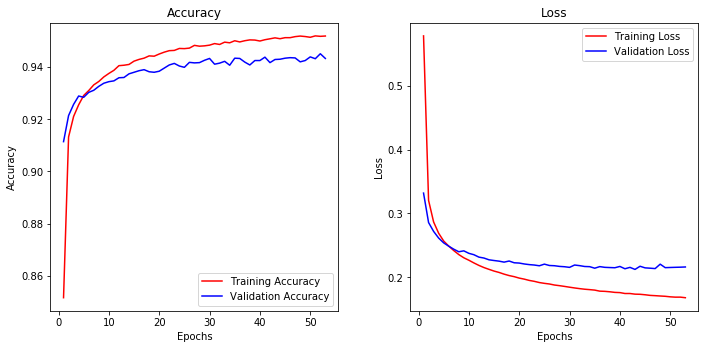

In [14]:
#@title Display Accuracy and Loss Graphs (double-click for code) { display-mode: "form" }
history_dict = history.history

train_loss = history_dict['loss']
train_acc = history_dict['accuracy']
val_loss = history_dict['val_loss']
val_acc = history_dict['val_accuracy']


epochs_range = range(1, len(train_loss)+1)

plt.rcParams.update(**rc_params)

plt.subplot(1,2,1)
plt.plot(epochs_range, train_acc, 'r', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'b', label='Validation Accuracy')
plt.title('Accuracy', fontdict=fontdict)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, train_loss, 'r', label='Training Loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation Loss')
plt.title('Loss', fontdict=fontdict)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplots_adjust(left=0,right=1.5,top=1,bottom=0,wspace=.25)

plt.show()

Total bad predictions: 571/10000
--------------------------------------------------------
Left   - the predicted digit
Right  - the probability of the prediction being correct
--------------------------------------------------------


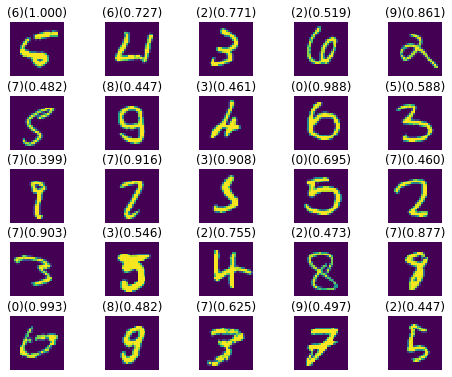

In [15]:
#@title Displays Examples of Bad Predictions (double-click for code) { display-mode: "form" }
bad_predictions = {}
for i, (y_true,y_pred) in enumerate(zip(test_labels,model.predict(X_test))):
  if y_true != y_pred.argmax():
    bad_predictions[i] = y_pred

print('Total bad predictions: %d/10000' % len(bad_predictions))

show_count = 25
cols = 5
rows = show_count//cols+(1 if show_count%cols != 0 else 0)

print('-'*56)
print('Left   - the predicted digit')
print('Right  - the probability of the prediction being correct')
print('-'*56)

for i,key in zip(range(show_count),bad_predictions.keys()):
  plt.subplot(rows,cols,i+1)
  plt.imshow(raw_test_images[key])
  plt.title('(%d)(%.3f)' % (bad_predictions[key].argmax(), bad_predictions[key].max()), fontdict=fontdict)
  plt.axis('off')

plt.subplots_adjust(left=0,right=1,top=1.25,bottom=0,wspace=.75,hspace=.1)
plt.show()